# Logistic Regression

In [2]:
# UCI repo -----------------------
from ucimlrepo import fetch_ucirepo

# Data Science -------------------
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning ---------------
from sklearn.model_selection import train_test_split
from sklearn.linear_model    import LogisticRegression
from sklearn.metrics         import confusion_matrix, classification_report

# Preprocessing -----------------
from sklearn.preprocessing   import MinMaxScaler
from sklearn.preprocessing   import OneHotEncoder as OHE

# Utils --------------------------
import sys  
sys.path.insert(1, '../utils')
import heatmatrix as hm
import preprocess as pp

## 1. Data
- Fetch from UCI
- Preprocess acordinto do [Dtype Optimization](/Users/felipecampelo/dev/projects/german_credit/notebooks/dtype_optimization.ipynb)

In [3]:
# Fetch and preprocess data

# Fetch
df = fetch_ucirepo(id=144).data.original

# Dtype preprocessing
df = pp.preprocess_dtypes(df)
pp.set_column_names(df)

# X and y
X = df.drop('Target', axis=1)
y = df['Target']

display(X.head())
display(y.head().to_frame())

,Checking Acc.,Duration (mo),Credit History,Purpose,Credit Amount,Savings Acc.,Employment Since,Installment/Income,Marital Status,Other Debtors,Residence Since,Property,Age,Other Installment,Housing,Existing Credits,Job,Dependents,Telephone,Foreigner
0,A11,6,A34,A43,1169,A65,A75,4,A93,A101,4,A121,67,A143,A152,2,A173,1,True,True
1,A12,48,A32,A43,5951,A61,A73,2,A92,A101,2,A121,22,A143,A152,1,A173,1,False,True
2,A14,12,A34,A46,2096,A61,A74,2,A93,A101,3,A121,49,A143,A152,1,A172,2,False,True
3,A11,42,A32,A42,7882,A61,A74,2,A93,A103,4,A122,45,A143,A153,1,A173,2,False,True
4,A11,24,A33,A40,4870,A61,A73,3,A93,A101,4,A124,53,A143,A153,2,A173,2,False,True


,Target
0,True
1,False
2,True
3,True
4,False


## 2. Train Test Split
> To enconde and scale the data we should:<br>
    1. Split into test and training sets.<br>
    2. Then encode the categoricals<br>
    3. And scale the actual numericals - disregard the new encoded columns<br>
    4. Finally concatenate both preprocessed techniques to new training and test sets  

In [4]:
# Train Test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [5]:
# Save train and test indices
X_train_indices = X_train.index
X_test_indices  = X_test.index

## 3. One-Hot-Encode

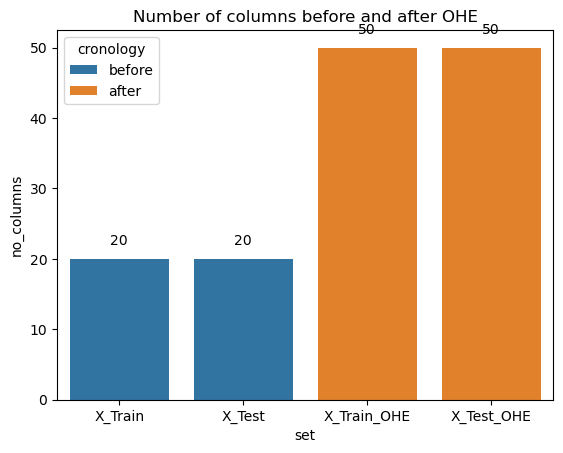

In [6]:
# Sparse OHE

# Categorical columns
categorical_columns = X.select_dtypes(include=['category']).columns

# Encoder
ohe = OHE(handle_unknown='ignore')

# Fit and transform
X_train_ohe = ohe.fit_transform(X_train[categorical_columns])
X_test_ohe  = ohe.transform    (X_test [categorical_columns])

# To DataFrame
X_train_categorical = pd.DataFrame(
    X_train_ohe.toarray(),
    columns=ohe.get_feature_names_out(categorical_columns),
    index=X_train_indices
)

X_test_categorical  = pd.DataFrame(
    X_test_ohe.toarray(),
    columns=ohe.get_feature_names_out(categorical_columns),
    index=X_test_indices
)

# Visualization
column_count = pd.DataFrame({
        'set' : ['X_Train', 'X_Test', 'X_Train_OHE', 'X_Test_OHE'],
        'no_columns': [X_train.shape[1], X_test.shape[1], X_train_categorical.shape[1], X_test_categorical.shape[1]],
        'cronology' : ['before', 'before', 'after', 'after']
    },
)

ax = sns.barplot(x='set', y='no_columns', data=column_count, hue='cronology')

# annotate
for i in range(column_count.shape[0]):
    ax.annotate(
        column_count.iloc[i, 1],
        (i, column_count.iloc[i, 1]),
        textcoords="offset points",
        xytext=(0,10),
        ha='center'
    )

plt.title('Number of columns before and after OHE')
plt.show()


# 4. MinMax Scale

In [7]:
# MinMaxScaler

numerical_columns = X.select_dtypes(include=np.number).columns

# Scaler
scaler = MinMaxScaler()

# Original stats
stats_original_train = X_train[numerical_columns].describe().loc[['mean', 'std']]
stats_original_test  = X_test [numerical_columns].describe().loc[['mean', 'std']]

# Scale the data 
X_train_scaled = scaler.fit_transform(X_train[numerical_columns])
X_test_scaled  = scaler.transform(    X_test [numerical_columns])

# To DataFrame 
X_train_numerical = pd.DataFrame(X_train_scaled, columns=numerical_columns, index=X_train_indices)
X_test_numerical  = pd.DataFrame(X_test_scaled,  columns=numerical_columns, index=X_test_indices)

# Scaled stats 
stats_scaled_train = X_train_numerical.describe().loc[['mean', 'std']]
stats_scaled_test  = X_test_numerical .describe().loc[['mean', 'std']]

In [8]:
# All stats in a single dataframe

# Concatenate orignal and scaled stats
train_stats = pd.concat([
    stats_original_train, 
    stats_scaled_train.rename(index={'mean':'mean_scaled', 'std':'std_scaled'})],
    axis=0
).T
train_stats['set'] = 'train'

test_stats = pd.concat([
    stats_original_test, 
    stats_scaled_test.rename(index={'mean':'mean_scaled', 'std':'std_scaled'})],
    axis=0
).T
test_stats['set'] = 'test'

# Concatenate all stats
stats = pd.concat([train_stats, test_stats], axis=0)

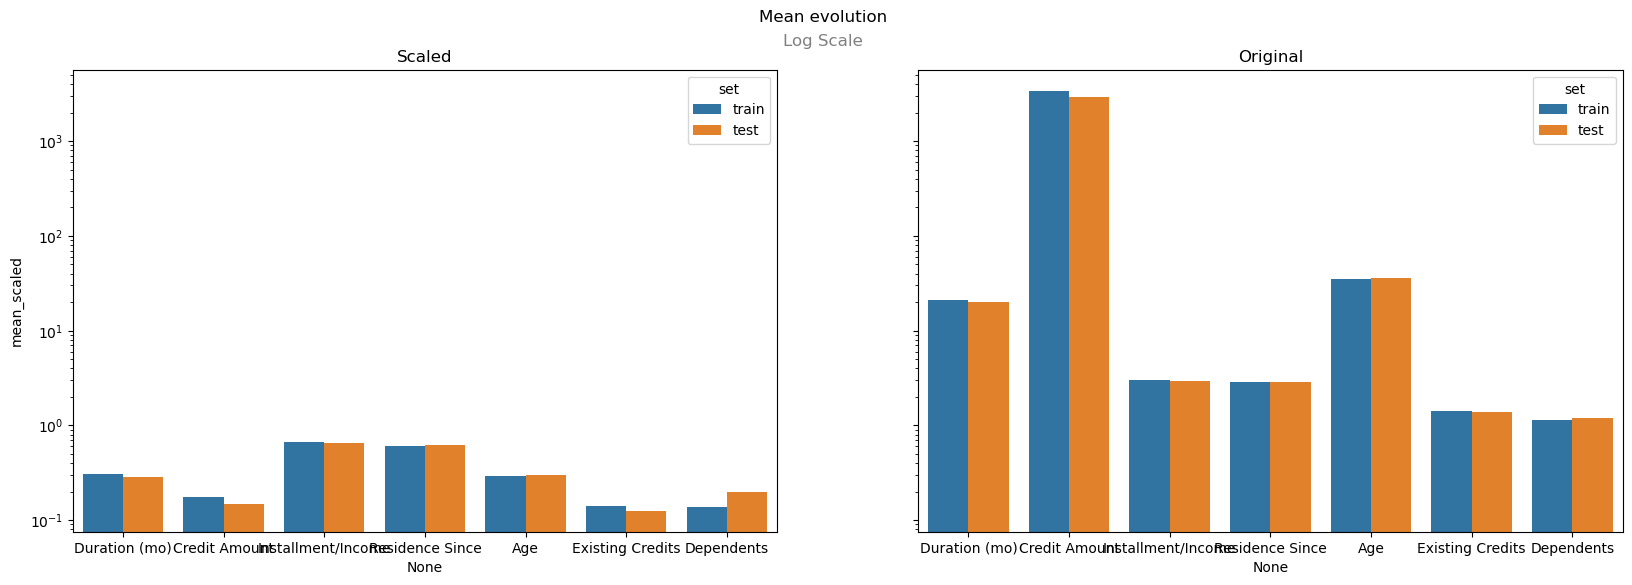

In [11]:
# # Mean visualization
fig, axes = plt.subplots(1, 2, figsize=(20, 6), sharey=True)
axes = axes.flatten()

# Scaled
sns.barplot(
    data = stats,
    x = stats.index, 
    y = 'mean_scaled',
    hue = 'set',
    ax = axes[0]
)

axes[0].set(yscale='log', title='Scaled')

# Original
sns.barplot(
    data = stats,
    x = stats.index, 
    y = 'mean',
    hue = 'set',
    ax = axes[1]
)

axes[1].set(title='Original')

plt.suptitle('Mean evolution')
fig.text(0.5, 0.92, 'Log Scale', ha='center', fontsize=12, color='gray')
plt.show()

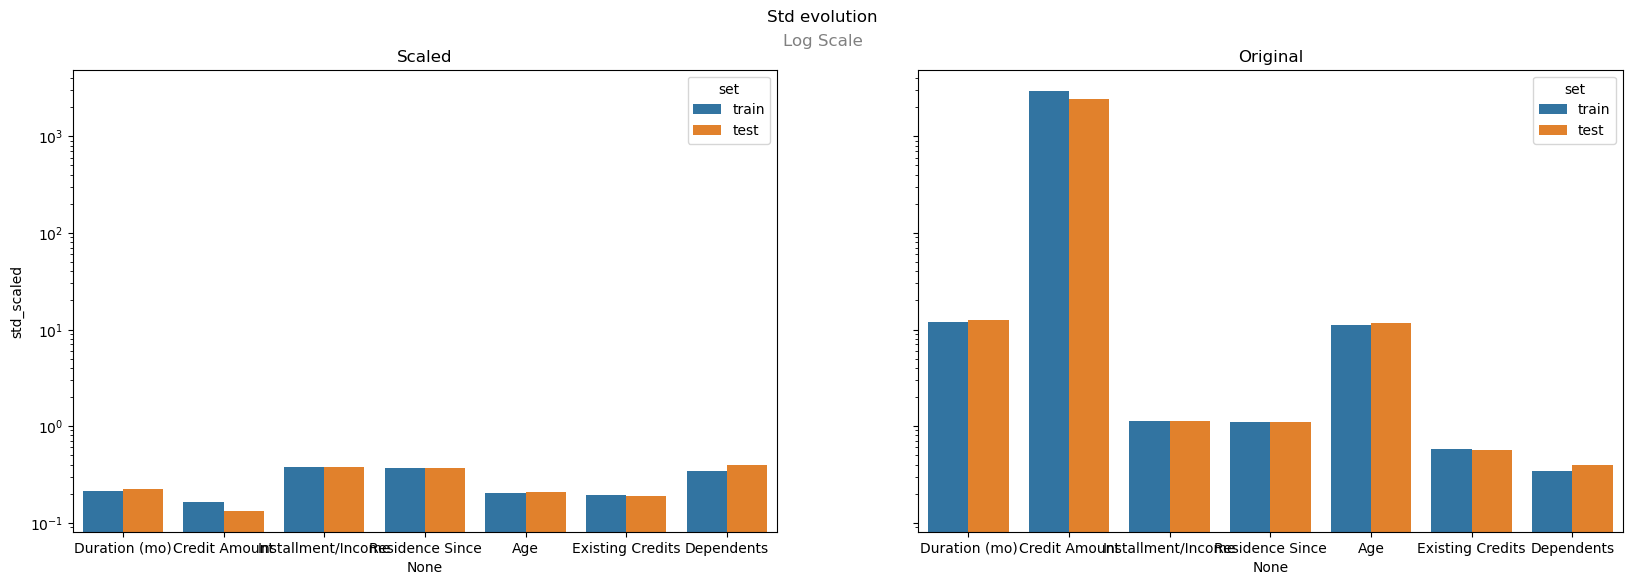

In [12]:
# Std visualization
fig, axes = plt.subplots(1, 2, figsize=(20, 6), sharey=True)
axes = axes.flatten()

# Scaled
sns.barplot(
    data = stats,
    x = stats.index, 
    y = 'std_scaled',
    hue = 'set',
    ax = axes[0]
)

axes[0].set(yscale='log', title='Scaled')

# Original
sns.barplot(
    data = stats,
    x = stats.index, 
    y = 'std',
    hue = 'set',
    ax = axes[1]
)

axes[1].set(title='Original')

plt.suptitle('Std evolution')
fig.text(0.5, 0.92, 'Log Scale', ha='center', fontsize=12, color='gray')
plt.show()

# 5. Blend everything back

In [13]:
# Train and Test preprocessed
X_train_preprocessed = pd.concat([X_train_categorical, X_train_numerical], axis=1)
X_test_preprocessed  = pd.concat([X_test_categorical,  X_test_numerical], axis=1)

display(f'Train {X_train_preprocessed.shape}', X_train_preprocessed.head())
display(f'Test  {X_test_preprocessed.shape}',  X_test_preprocessed.head())

'Train (700, 57)'

,Checking Acc._A11,Checking Acc._A12,Checking Acc._A13,Checking Acc._A14,Credit History_A30,Credit History_A31,Credit History_A32,Credit History_A33,Credit History_A34,Purpose_A40,...,Job_A172,Job_A173,Job_A174,Duration (mo),Credit Amount,Installment/Income,Residence Since,Age,Existing Credits,Dependents
541,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,...,0.0,1.0,0.0,0.357143,0.098052,1.000000,1.000000,0.732143,0.333333,0.0
440,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.142857,0.089909,1.000000,1.000000,0.357143,0.000000,0.0
482,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.464286,0.185540,1.000000,1.000000,0.678571,0.333333,0.0
422,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,0.0,0.142857,0.038957,0.333333,0.666667,0.500000,0.333333,1.0
778,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.571429,0.300484,1.000000,0.333333,0.339286,0.333333,0.0


'Test  (300, 57)'

,Checking Acc._A11,Checking Acc._A12,Checking Acc._A13,Checking Acc._A14,Credit History_A30,Credit History_A31,Credit History_A32,Credit History_A33,Credit History_A34,Purpose_A40,...,Job_A172,Job_A173,Job_A174,Duration (mo),Credit Amount,Installment/Income,Residence Since,Age,Existing Credits,Dependents
521,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.250000,0.161770,0.333333,0.333333,0.089286,0.000000,0.0
737,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.250000,0.227248,0.666667,1.000000,0.285714,0.000000,1.0
740,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.357143,0.114174,0.333333,0.666667,0.232143,0.000000,0.0
660,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.142857,0.057610,0.666667,1.000000,0.071429,0.000000,0.0
411,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.517857,0.385331,0.666667,0.333333,0.285714,0.333333,0.0


## 6. Model

In [14]:
# Logistic Regression
logreg = LogisticRegression().fit(X_train_preprocessed, y_train)

# Predictions
y_pred = logreg.predict(X_test_preprocessed)

## 7. Metrics

<Axes: >

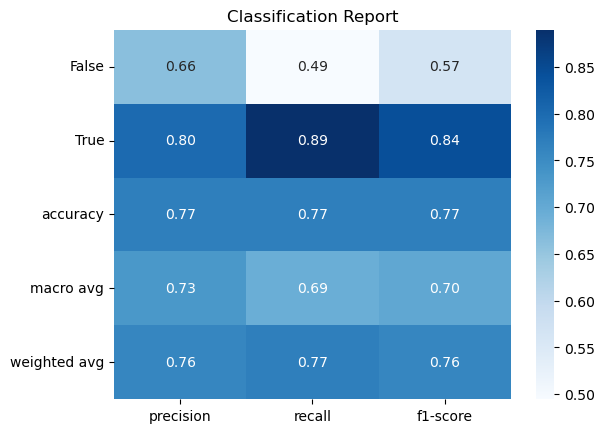

In [15]:
# Model in a Classification Report
cr = pd.DataFrame(classification_report(y_test, y_pred, output_dict=True)).T
# display(cr)

# Classification Report Heatmap
display(sns.heatmap(cr.drop(columns='support'), annot=True, fmt='.2f', cmap='Blues'))
plt.title('Classification Report')
plt.show()

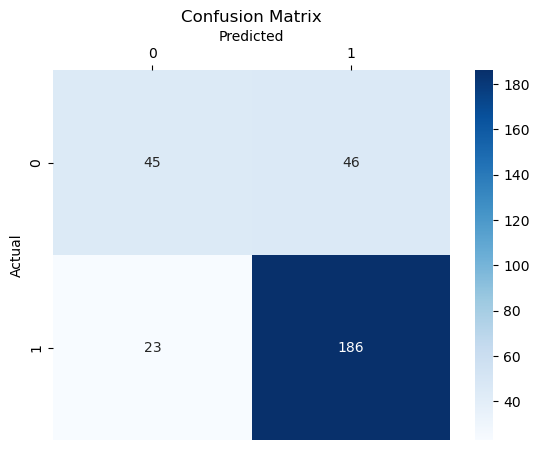

In [18]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
hm.cm_heatmap(cm, 'Blues')
plt.title('Confusion Matrix')
plt.show()

> The logistic model is rather low performant on the false targets.<br>
> This represents a model that can potentially harm the institution's finance.<br>

> That might be due to imbalances in the dataset 
which is comfirmed by the 70/30 distributions seen in [German Credit @4.4 Distributions](/Users/felipecampelo/dev/projects/german_credit/notebooks/the_data.ipynb)

## 8 Cost Matrix
Actual, Predicted
|     | 0   |  1  |
|---|---|----|
| 0   | 0      |  5|
| 1  | 1     |  0|

(1 = Good,  0 = Bad)

> - actual 0 as 1: 5 -> Labeling bad loaners as good credit risk may result in financial loss.<br>
> - actual 1 as 0: 1 -> Whereas not labeling good loaners as good credit risk may only result in a loss of potential profit.<br>
> - cost for correct predictions is 0.

In [46]:
cost_matrix = np.array([[0, 1], [5, 0]])
display('confusion_matrix', pd.DataFrame(cm))
display('cost_matrix',      pd.DataFrame(cost_matrix))
print('Model`s Cost:                       ', model_cost := np.sum(cm * cost_matrix))
print('Total Financial Loss cost:          ', max_cost   := 5*len(y_test), )
print(f'Percentage over max possible cost:   {(model_cost / max_cost * 100):.2f}%')
print('Total Profit Potentential Lost cost:', 1*len(y_test))

'confusion_matrix'

,0,1
0,45,46
1,23,186


'cost_matrix'

,0,1
0,0,1
1,5,0


Model`s Cost:                        161
Total Financial Loss cost:           1500
Percentage over max possible cost:   10.73%
Total Profit Potentential Lost cost: 300


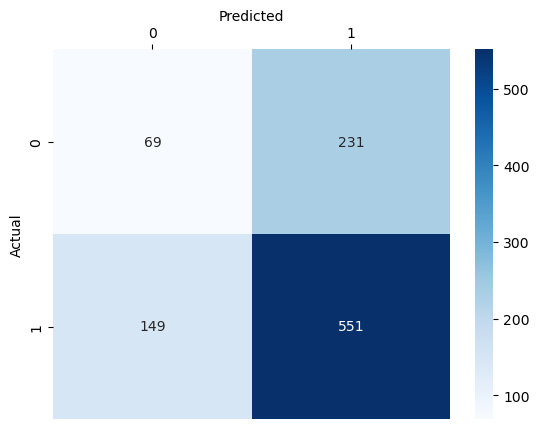

In [47]:
# Predict on the entire data set
y_pred_all = logreg.predict(pd.concat([X_train_preprocessed, X_test_preprocessed], axis=0))
cm_all = confusion_matrix(y, y_pred_all)
hm.cm_heatmap(cm_all, 'Blues')

In [48]:
# Model`s Cost
print('Model`s Cost:                       ', model_cost := np.sum(cm_all * cost_matrix))
print('Total Financial Loss cost:          ', max_cost   := 5*len(y), )
print(f'Percentage over max possible cost:   {(model_cost / max_cost * 100):.2f}%')
print('Total Profit Potentential Lost cost:', 1*len(y))

Model`s Cost:                        976
Total Financial Loss cost:           5000
Percentage over max possible cost:   19.52%
Total Profit Potentential Lost cost: 1000
